## Installing the NAG Library and running this notebook
The model in this notebook is solved by the NAG MILP solver featured in the NAG Optimization Modelling Suite. To run this notebook, you will need to install the NAG Library for Python (Mark 29.3 or newer) and a license key. You can find the software and obtain a license key (trials are available) from [Getting Started with the NAG Library](https://www.nag.com/content/getting-started-nag-library?lang=py&os=linuxto).


## **Battery sizing problem in a Grid-connected Microgrid using MILP in the NAG Library**

Energy storage systems (ESS) are increasingly recognized as vital components of traditional power grids combined with renewable energy sources for several reasons. Firstly, the stability and reliability of the power grids can be enhanced by ESS, which provides fast-response ancillary services such as frequency regulation, voltage control, and grid balancing. These services help mitigate the impact of sudden fluctuations in electricity demand or supply, reducing the risk of blackouts and ensuring a more resilient grid infrastructure. Secondly, ESS allows utilities to shift electricity generation from times of low demand to times of peak demand, helping to manage load profiles more effectively. Moreover, ESS plays an important role in helping smooth out the variability and intermittency associated with renewable resources such as solar and wind power. This enables greater penetration of renewable energy into the grid without compromising reliability or stability.

At Mark 29.3 the NAG Library features a new Mixed Integer Linear Programming (MILP) solver, which is a powerful tool for the design and operation of energy storage systems, including optimal sizing and configuration, energy management and dispatch, and risk management. In order to illustrate the usage of the MILP solver, we build the model and solve an optimal battery sizing problem for a microgrid that is connected to an external grid and consists of a battery energy storage system (BESS), several generators and loads. The model also provides optimal operation of the system, including generator scheduling and power dispatch, battery charging and discharging schedule and optimal grid power import. 

### **Microgrid Modelling**

The microgrid of interest in this notebook is depicted in Figure 1. Loads demand can be fulfilled by generators, batteries and the external grid. Generators are assumed to be owned by a utility, therefore the energy management system will find an optimal schedule for all components to minimize the operation cost of generators and the battery. The planning horizon $N$ is set to 24 hours.

<img src="Grid_Model.png" alt="GRID" width="500" height="200">

Figure 1: Grid-connected microgrid model

#### **Decision variables**

The decision variables controlling various components in the microgrid are listed below.
- Generators
  - $p_{ij}^g$: dispatched power from the $i$-th generator at the $j$-th hour.
  - $s_{ij}$: binary switch that is equal to 1 if the $i$-th generator is online and 0 otherwise at the $j$-th hour.
- BESS
  - $p^b_j$: power discharged or charged to the battery energy storage system at the $j$-th hour.
  - $c^b$: power rate of the battery energy system.
  - $e^b$: energy rate of the battery energy system.
- External grid
  - $p_j^{im}$: imported power at the $j$-th hour.

#### **Model parameters and coefficients**

The model parameters are defined directly in the code cell below for building the model later. See the comments for the description of each parameter. Fuel cost of the generators are usually calculated using a quadratic function. Based on the property of the quadratic function, in practice it is reasonable to linearize it using piecewise functions and then make use of the powerful MILP solver. In this notebook, we'll simply adopt a linear approximation to the quadratic function for illustration purposes.

In [65]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generator parameters
# Number of generators
n_gen = 3
# Data frame for the specifications of the generators
df = pd.DataFrame(
    {
    'Gen1':[0.010694, 142.7348, 30, 70, 8, 6],
    'Gen2':[0.018761, 168.9075, 50, 100, 8, 6],
    'Gen3':[0.0076121, 313.9102, 30, 120, 8, 6],
    }
)
df.index=['a','b','pl','pu','ut','dt']
print(df.T.to_string())
spec_gen = df.T.to_numpy() 

             a         b    pl     pu   ut   dt
Gen1  0.010694  142.7348  30.0   70.0  8.0  6.0
Gen2  0.018761  168.9075  50.0  100.0  8.0  6.0
Gen3  0.007612  313.9102  30.0  120.0  8.0  6.0


The above DataFrame contains all the specification of the generators. The fuel cost is defined as the linear function
$$
cost_i(p_{ij}^g) = a_i * p_{ij}^g + b_i
$$
for generator $i$ at the $j$-th hour. $pl$ and $pu$ are the minimum and maximum power output of the $i$-th generator respectively. The rest of the parameters are
- $ut$: minimum up time of the generator
- $dt$: minimum down time of the generator

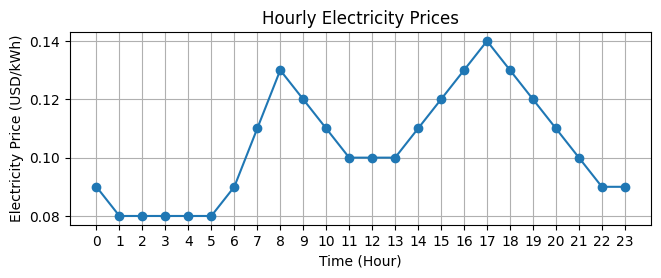

In [66]:
# Battery parameters
cost_bat_power = 0.2
cost_bat_energy = 0.25
# External grid import price
cost_imp_energy = np.array([
    0.09, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09,  # 12:00 AM - 6:00 AM
    0.11, 0.13, 0.12, 0.11, 0.10, 0.10, 0.10,  # 7:00 AM - 1:00 PM
    0.11, 0.12, 0.13, 0.14, 0.13, 0.12, 0.11,  # 2:00 PM - 7:00 PM
    0.10, 0.09, 0.09                         # 8:00 PM - 11:00 PM
])

# Number of hours in the planning horizon
n_hours = 24

# Plot import energy cost
plt.figure(figsize=(7.5, 2.5))
plt.plot(np.arange(n_hours), cost_imp_energy, marker='o')
plt.title('Hourly Electricity Prices')
plt.xlabel('Time (Hour)')
plt.ylabel('Electricity Price (USD/kWh)')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.show()

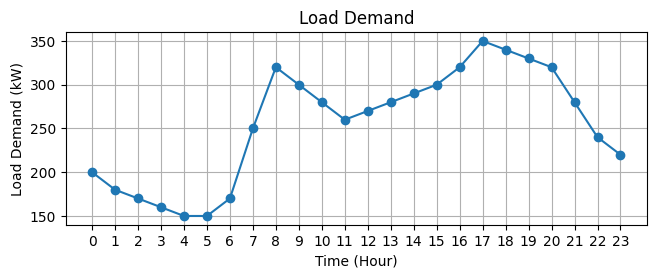

In [67]:
# Load demand to be fulfilled by the energy management system
load_demand = np.array([
    200, 180, 170, 160, 150, 150, 170, 250, 320, 300, 280, 260, 270, 280, 290, 
    300, 320, 350, 340, 330, 320, 280, 240, 220
])

# Plot load demand
plt.figure(figsize=(7.5, 2.5))
plt.plot(np.arange(n_hours), load_demand, marker='o')
plt.title('Load Demand')
plt.xlabel('Time (Hour)')
plt.ylabel('Load Demand (kW)')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.show()

### **Mixed Integer Linear Programming using the NAG Library**

In [68]:
# Import the NAG Library for Python
from naginterfaces.base import utils
from naginterfaces.library import opt, mip

# Total number of variables in the model
# generators: 3 * 24 * 2
# battery: 24 + 2
# power import: 24
#       pg  + pim + cb + eb + pb +  s   
nvar = 3*24 + 24  + 1  + 1  + 24 + 3*24 

# Create a problem handle to hold model data
handle = opt.handle_init(nvar=nvar)

The objective function which is the total operation cost of the utility is defined as
$$
\min \sum_{j=1}^{n\_hours} (\sum_{i=1}^{n\_gen} cost_i(p_{ij}^g) + cost\_imp\_energy_j*p_{j}^{im}) + cost\_bat\_power * c^b + cost\_bat\_energy * e^b
$$

In [69]:
# Set objective coefficient
idxc = list(range(1, 3*24 + 24  + 1  + 1 + 1))
c = np.tile(spec_gen[:,0], 24)
c = np.concatenate((c, cost_imp_energy, [cost_bat_power, cost_bat_energy]))

# Set model objective
opt.handle_set_quadobj(handle=handle, idxc=idxc, c=c)

The load balance of every hour needs to be met, therefore we have the following power balance for $j$-th hour:
$$
\sum_{i=1}^{n\_gen} p^g_{ij} + p^b_j + p^{im}_j = load\_demand_j.
$$

In [70]:
# Add power balance constraint for each hour
for hour in range(n_hours):
	irowa = np.full(5, 1, dtype=int)
	icola = np.array([3*hour+1, 3*hour+2, 3*hour+3, 3*24+hour+1, 3*24+24+1+1+hour+1], dtype=int)
	a = np.full(5, 1.0, dtype=float)
	bl = np.full(1, load_demand[hour], dtype=float)
	bu = np.full(1, load_demand[hour], dtype=float)
	opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)

The generators' power output should be within the limits given as $pl$ and $pu$ in the generators specification, when they are online. Therefore the generators limits constraint for the $i$-th generator at the $j$-th hour is defined as
$$
pl_i*s_{ij} \leq p^g_{ij} \leq pu_i*s_{ij}.
$$

In [71]:
# Add generator limits constraint
for generator in range(n_gen):
	for hour in range(n_hours):
		irowa = [1, 1, 2, 2]
		icola = np.tile([3*24+24+1+1+24+hour*3+generator+1, hour*3+generator+1],2)
		a = np.array([spec_gen[generator, 2], -1.0, spec_gen[generator, 3], -1.0], dtype=float)
		bl = np.array([-1.e20, 0.])
		bu = np.array([0., 1.e20])
		opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)

Each generator has a minimum up and down time constraint:
$$
\sum_{t=j}^{j+ut-1} s_{it} \geq ut*(s_{ij}-s_{ij-1}),
$$
$$
\sum_{t=j}^{j+dt-1} (1 - s_{it}) \geq dt*(s_{ij-1}-s_{ij}).
$$
Note we assume all generators have the same minimum up time and minimum down time for simplicity.

In [72]:
# Add minimum up and down time constraints
ut = 8.0
dt = 6.0
s_start = 3*24 + 24  + 1  + 1  + 24
# minimum up time constraints
for generator in range(n_gen):
	for hour in range(1, n_hours):
		irowa = np.array([],dtype=int)
		icola = np.array([],dtype=int)
		a = np.array([],dtype=float)
		for i in range(hour-1, min(hour+ 8, n_hours)):
			icola = np.append(icola, s_start+i*3+generator+1)
			irowa = np.append(irowa, 1)
			a = np.append(a, 1.0)
		a[0] = ut 
		a[1] = 1 - ut
		bl = 0.0
		bu = 1.e20
		opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)
# minimum down time constraints
for generator in range(n_gen):
	for hour in range(1, n_hours):
		irowa = np.array([],dtype=int)
		icola = np.array([],dtype=int)
		a = np.array([],dtype=float)
		bu = -1.0
		for i in range(hour-1, min(hour+ 6, n_hours)):
			icola = np.append(icola, s_start+i*3+generator+1)
			irowa = np.append(irowa, 1)
			a = np.append(a, 1.0)
			bu += 1.0
		a[0] = dt 
		a[1] = 1 - dt
		bl = -1.e20
		opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)

Battery power at any time cannot be off the limits. Therefore we define the following power rating limits constraint.
$$
-c^b \leq p^b_j \leq c^b.
$$

In [73]:
# Add battery power limits constraints
for hour in range(n_hours):
	irowa = [1, 1, 2, 2]
	icola = [3*24+24+1+1+hour+1, 3*24+24+1, 3*24+24+1+1+hour+1, 3*24+24+1]
	a = [1.0, -1.0, 1.0, 1.0]
	bl = [-1.e20, 0.]
	bu = [0., 1.e20]
	opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)

Energy rating of the battery storage system follows
$$
-e^b \leq \sum_{j=1}^t p^b_j \leq 0, for ~t = 1, \ldots, n\_hours.
$$

In [74]:
# Add battery energy limits constraints
for hour in range(n_hours):
	# rhs
	irowa = np.array([],dtype=int)
	icola = np.array([],dtype=int)
	a = np.array([],dtype=float)
	for i in range(hour+1):
		icola = np.append(icola, 3*24+24+1+1+i+1)
		irowa = np.append(irowa, 1)
		a = np.append(a, 1.0)
	bl = -1.e20
	bu = 0.
	opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)
	# lhs
	irowa = np.array([1],dtype=int)
	icola = np.array([3*24+24+1+1],dtype=int)
	a = np.array([1.],dtype=float)
	for i in range(hour+1):
		icola = np.append(icola, 3*24+24+1+1+i+1)
		irowa = np.append(irowa, 1)
		a = np.append(a, 1.0)
	bl = 0.
	bu = 1.e20
	opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)

The imported power is limited to $15$ kW maximum.
$$
0 \leq p^{im}_j \leq 15.
$$

In [75]:
# Add limits to the imported power
for i in range(n_hours):
	opt.handle_set_bound(handle=handle, comp='Var', idx=3*24+i+1, bli=0., bui=15.)

In [76]:
# Switches for the generators are binary
switches = np.arange(3*24+24+1+1+24+1, nvar+1)
opt.handle_set_property(handle=handle, ptype='Bin', idx=switches)

In [77]:
# Set options
for option in [
        'Print Options = NO',
        'Print Level = 1',
]:
    opt.handle_opt_set(handle, option)

# Use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

# Solve the problem.
x, _, _ = mip.handle_solve_milp(handle, io_manager=iom)

# Destroy the handle:
opt.handle_free(handle)

 H02BK, Solver for MILP problems
 Status: converged, an optimal solution found
 Final primal objective value  1.218345E+02
 Final dual objective bound    1.218345E+02


Now we can extract the optimal configuration from the solution.

In [78]:
# Generator schedule for 24 hours
switch1 = np.array([x for i, x in enumerate(x[-3*24:]) if i % 3 ==0])
switch2 = np.array([x for i, x in enumerate(x[-3*24:]) if i % 3 ==1])
switch3 = np.array([x for i, x in enumerate(x[-3*24:]) if i % 3 ==2])
# Generator energy for 24 hours
generator1 = np.array([x for i, x in enumerate(x[:3*24]) if i % 3 ==0])
generator2 = np.array([x for i, x in enumerate(x[:3*24]) if i % 3 ==1])
generator3 = np.array([x for i, x in enumerate(x[:3*24]) if i % 3 ==2])
# Power import
power_import = x[3*24 : 3*24+24]
battery_power_rate = x[3*24+24]
battery_energy_rate = x[3*24+24+1]
battery_power = x[3*24+24+1+1 : 3*24+24+1+1+24]

df = pd.DataFrame(
	{
	'Battery':[battery_power_rate, battery_energy_rate],
	}
)
df.index=['Power Rate','Energy Rate']
print(df.T.to_string())

         Power Rate  Energy Rate
Battery        45.0        135.0


The model gives the optimal battery power rate as $45$ kW and optimal energy rate as $135$ kWh. We can plot the battery discharging schedule and energy import schedule as below. It's shown that the battery charges itself during off-peak time and dispatches during peak hours to mitigate the need of importing external energy. The imported energy is kept well under $15$ kW and only happens during the second peak.

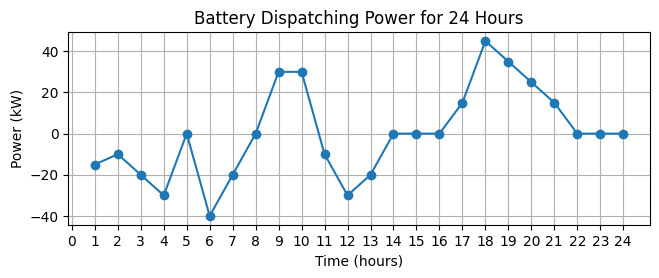

In [79]:
# Plot dispatching from battery energy storage system
plt.figure(figsize=(7.5, 2.5))
plt.plot(np.arange(1, n_hours+1), battery_power, marker='o', linestyle='-')
plt.title('Battery Dispatching Power for 24 Hours')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(True)
plt.show()

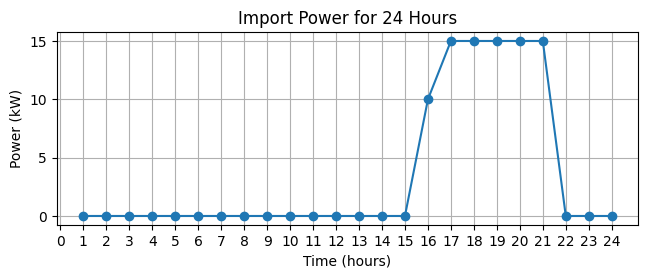

In [80]:
# Plot power import from external grid
plt.figure(figsize=(7.5, 2.5))
plt.plot(np.arange(1, n_hours+1), power_import, marker='o', linestyle='-')
plt.title('Import Power for 24 Hours')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(True)
plt.show()

### **Conclusion**

In this notebook, we illustrated how to use the MILP solver featured in the NAG Optimization Modelling Suite from the NAG Library to model a microgrid and design it's battery energy storage system capacity. The model is also able to give operational schedules for various components in the microgrid. The model can be easily extended with additional components, such as additional power source from solar panels or wind farms and more switchable loads. The [NAG MILP solver](https://support.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.mip.handle_solve_milp.html) serves as a powerful tool for modelling and managing energy systems. Learn more about it [here](https://nag.com/mixed-integer-linear-programming/). 